In [1]:
import sys
!conda install --yes --prefix {sys.prefix} matplotlib pandas scikit-learn
!{sys.executable} -m pip install python-louvain multiprocess
%matplotlib inline

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda




In [2]:
import networkx as nx
from networkx.algorithms import community as algorithms
from networkx.generators import community as generator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import normalized_mutual_info_score
import math 
import itertools
from collections import OrderedDict, Counter
import pandas as pd
import multiprocess as mp
plt.rcParams["figure.figsize"]=20,10

Drawing some community network graphs and predictions


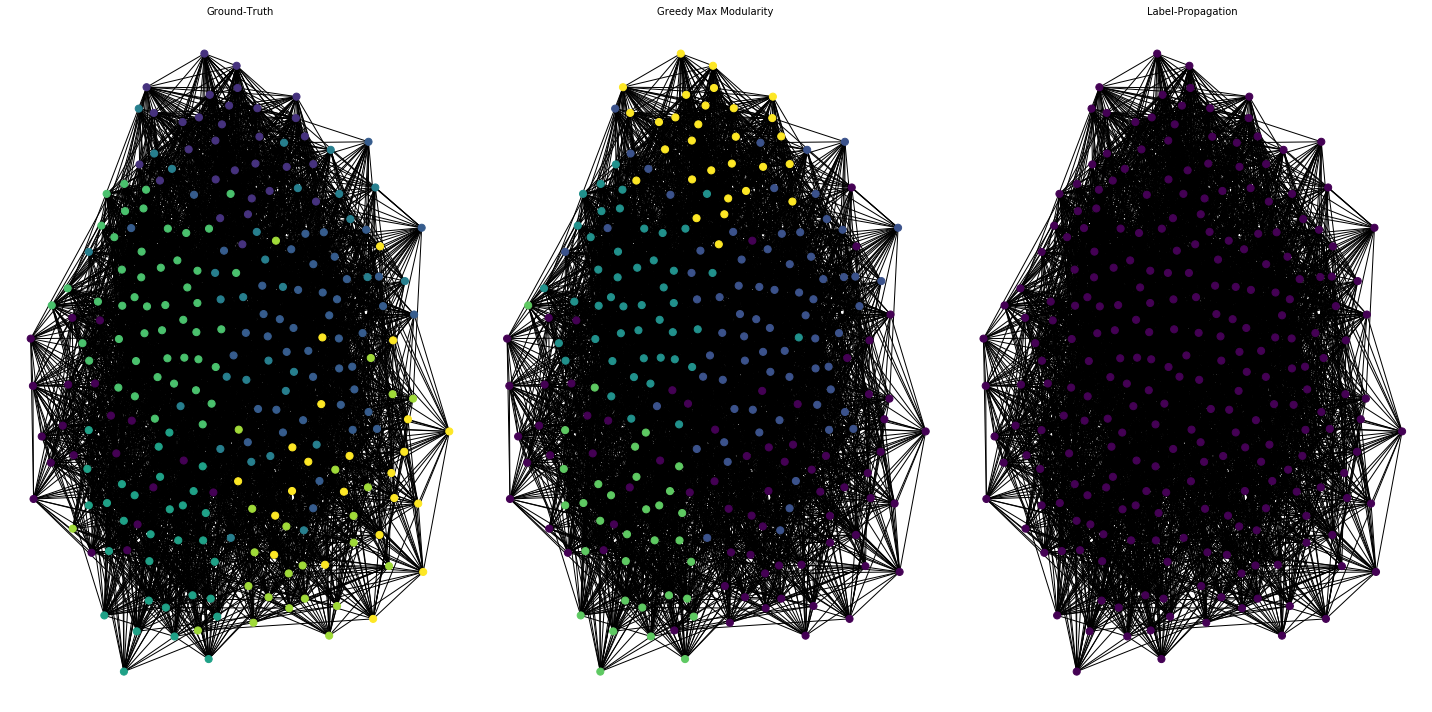

In [3]:
def generate_test_graphs(iterations):
    for i in iterations:
        print(f"Iteration number {i}")
        yield

def extract_true_communities(G):
    communities = []
    for v in G:
        curr_community = G.nodes[v]['community']
        if not any([v in community for community in communities]):
            communities.append(frozenset(curr_community))
    partition = extract_partition_map(communities)
    return partition, communities

def extract_partition_map(communities):
    node_community_participation = {node:idx for idx, community in enumerate(communities) for node in community}
    return OrderedDict(sorted(node_community_participation.items()))

def generate_benchmark_graph(n, mu=0.1):
    tau1 = 2 # Degree distribution power-law exponent
    tau2 = 1.1 # Community size distribtution power-law exponent
    G = generator.LFR_benchmark_graph(n, tau1, tau2, mu, min_degree=20, max_degree=50, max_iters=1000, seed=10)
    pos = nx.spring_layout(G, k=.3)
    return G, pos

def visualize_benchmark_graph(G, pos, partition, ax=None):
    return nx.draw_networkx(G, 
    pos, 
    edge_color="black", 
    with_labels=False, 
    node_size=50, 
    cmap=plt.cm.viridis, 
    node_color=list(partition.values()), 
    ax=ax)

# %%
print(f"Drawing some community network graphs and predictions")
G, pos = generate_benchmark_graph(250,0.3)
true_partition_map, communities = extract_true_communities(G)
communities = algorithms.greedy_modularity_communities(G)
cnm_partition_map = extract_partition_map(communities)
communities = algorithms.asyn_lpa_communities(G)
lpa_partition_map = extract_partition_map(communities)

# fig = plt.figure(figsize=(10, 10), dpi= 80); #plt.clf()
fig, ax = plt.subplots(1, 3)
ax[0].set_title(f"Ground-Truth", fontsize=10)
ax[0].set_axis_off()
ax[1].set_title(f"Greedy Max Modularity ", fontsize=10)
ax[1].set_axis_off()
ax[2].set_title(f"Label-Propagation", fontsize=10)
ax[2].set_axis_off()
visualize_benchmark_graph(G, pos, true_partition_map, ax[0])
visualize_benchmark_graph(G, pos, cnm_partition_map, ax[1])
visualize_benchmark_graph(G, pos, lpa_partition_map, ax[2])
plt.tight_layout()
plt.show()

In [4]:
def compute_entropy(partition_map):
    class_counts = np.array(list(Counter(partition_map.values()).values()))
    class_probabilities = class_counts/sum(class_counts) 
    partial_entropies = - class_probabilities * np.log2(class_probabilities)
    entropy = partial_entropies.sum() 
    return entropy

def compute_conditional_entropy(hx, hy, hxy):
    return hx + hy - hxy

def compute_joint_entropy(true_partitions, pred_partitions):
    cnt_matrix = contingency_matrix(list(true_partitions.values()), list(pred_partitions.values())).T
    matrix_sum = cnt_matrix.sum()
    prob_matrix = cnt_matrix / matrix_sum
    joint_entorpy = -np.nansum(prob_matrix*np.log2(prob_matrix))
    return joint_entorpy

def normalized_mutual_information(true_partitions, pred_partitions):
    H_X = compute_entropy(true_partitions)
    H_Y = compute_entropy(pred_partitions)
    H_XY = compute_joint_entropy(true_partitions, pred_partitions)
    conditional_entropy =  compute_conditional_entropy(H_X, H_Y, H_XY)
    sum_of_independent_entropies = H_X + H_Y
    nominator = 2 * conditional_entropy
    denominator = sum_of_independent_entropies
    return nominator/denominator

true_nmi = normalized_mutual_information(true_partition_map, true_partition_map)
cnm_nmi = normalized_mutual_information(true_partition_map, cnm_partition_map)
cnm_nmi_reversed = normalized_mutual_information(cnm_partition_map, true_partition_map)
lpa_nmi = normalized_mutual_information(true_partition_map, lpa_partition_map)

assert math.isclose(true_nmi, 1), f"True nmi does not equal one with the score of {true_nmi}"
print(f"NMI of true prediction with true prediction amounts to {true_nmi} == 1.0.")

# print(f"Sklearn {normalized_mutual_info_score(list(true_partition_map.values()), list(true_partition_map.values()))} == 1")
assert cnm_nmi < 1, f"Clauset-Moore-Newman not below 1 with {cnm_nmi}"
print(f"NMI of ground truth with cnm prediction amounts to {cnm_nmi} < 1")

assert cnm_nmi == cnm_nmi_reversed, f"NMI score for NMI(X,Y) is not the same as NMI(Y,X)"
print(f"Reversed NMI score is {cnm_nmi_reversed}")

assert cnm_nmi < 1, f"Label propagation is not below 1 with {lpa_nmi}"
print(f"NMI of ground truth with lpa prediction amounts to {lpa_nmi} < 1")


NMI of true prediction with true prediction amounts to 1.0 == 1.0.
NMI of ground truth with cnm prediction amounts to 0.7699400310176202 < 1
Reversed NMI score is 0.7699400310176202
NMI of ground truth with lpa prediction amounts to 0.0 < 1


<ipython-input-4-1a6f4ed19428>:15: RuntimeWarning: divide by zero encountered in log2
  joint_entorpy = -np.nansum(prob_matrix*np.log2(prob_matrix))
<ipython-input-4-1a6f4ed19428>:15: RuntimeWarning: invalid value encountered in multiply
  joint_entorpy = -np.nansum(prob_matrix*np.log2(prob_matrix))


In [15]:
import utils
algorithms_for_experiment = [
    algorithms.greedy_modularity_communities,
    algorithms.asyn_lpa_communities
    ]
collected_data = []
iterations = list(range(0,1))
node_sizes = [250, 500]
mus = np.arange(0.1, 1., 0.1)
configuration_set = itertools.product(*[iterations, algorithms_for_experiment, node_sizes, mus])

cpu_cnt = mp.cpu_count()
with mp.Pool(cpu_cnt) as pool:
    print(f"Running experiments in parallel with {cpu_cnt} cpus")
    parallel_execution_data = pool.map(utils.compute_experiment, configuration_set)

data = pd.DataFrame(collected_data)

Running experiments in parallel with 12 cpus


In [14]:
aggregated_over_trials = data.groupby(['method', 'N', 'µ']).mean()
grouped_by_algorithm = aggregated_over_trials.groupby(['method'])
num_groups = len(grouped_by_algorithm)
tmp = None
fig, axes = plt.subplots(num_groups//2, 2, sharex=True, sharey=True) 
fig.set_size_inches(10, 5)
# fig = plt.figure(figsize=(10, 10), dpi= 80)
for idx, (algorithm_name, algorithm_data) in enumerate(grouped_by_algorithm):
    # tmp = algorithm_data.unstack(level=[0,1])
    axes[idx].set_title(algorithm_name)
    tmp = algorithm_data.reset_index().pivot(index='µ', columns='N', values='NMI')
    tmp.plot(ax=axes[idx])
    axes[idx].set_ylabel("Normalized Mutual Information")

fig.set_tight_layout(True)
plt.show()

[{'method': 'greedy_modularity_communities',
  'N': 250,
  'µ': 0.1,
  'NMI': 0.8189368746915584},
 {'method': 'greedy_modularity_communities',
  'N': 250,
  'µ': 0.2,
  'NMI': 0.885291274950468},
 {'method': 'greedy_modularity_communities',
  'N': 250,
  'µ': 0.30000000000000004,
  'NMI': 0.3056370084445638},
 {'method': 'greedy_modularity_communities', 'N': 250, 'µ': 0.4, 'NMI': 0.0},
 {'method': 'greedy_modularity_communities', 'N': 250, 'µ': 0.5, 'NMI': 0.0},
 {'method': 'greedy_modularity_communities', 'N': 250, 'µ': 0.6, 'NMI': 0.0},
 {'method': 'greedy_modularity_communities',
  'N': 250,
  'µ': 0.7000000000000001,
  'NMI': 0.0},
 {'method': 'greedy_modularity_communities', 'N': 250, 'µ': 0.8, 'NMI': 0.0},
 {'method': 'greedy_modularity_communities', 'N': 250, 'µ': 0.9, 'NMI': 0.0},
 {'method': 'greedy_modularity_communities',
  'N': 500,
  'µ': 0.1,
  'NMI': 0.9656933661357487},
 {'method': 'greedy_modularity_communities',
  'N': 500,
  'µ': 0.2,
  'NMI': 0.9515489196825089},
 